In [1]:
import pyam
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.container import ErrorbarContainer
from matplotlib.collections import LineCollection

<IPython.core.display.Javascript object>

Step 1: Read in the data and filter for the necessary variables.

In [2]:
df = pyam.IamDataFrame(
    Path(
        '../data/101_data.xlsx'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/101_data.xlsx
pyam.core - INFO: Reading meta indicators


Step 2: Read in the cumulative fair shares estimate.

In [3]:
fair_shares = pd.read_excel(
    Path(
        '../data/102_fair_share_benchmarks.xlsx'
    ),
    index_col=[0,1]
)

In [4]:
reg_maps = {
    'R5OECD90+EU':['R10NORTH_AM', 'R10EUROPE', 'R10PAC_OECD'],
    'R5REF': 'R10REF_ECON',
    'R5ASIA': ['R10CHINA+', 'R10INDIA+', 'R10REST_ASIA'],
    'R5LAM': 'R10LATIN_AM',
    'R5MAF': ['R10AFRICA', 'R10MIDDLE_EAST']
}

In [5]:
df_1p5 = (
    df
    .filter(
        Category='C1',
        variable=[
            'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
            'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
            'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total',
            'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
            'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross'
        ]
    )
)

Step 2: Determine the color schemes.

In [6]:
df_1p5.region

['R5ASIA', 'R5LAM', 'R5MAF', 'R5OECD90+EU', 'R5REF', 'World']

In [7]:
variable_components = [
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross'
]

In [8]:
column_net_zero = 'Year of netzero CO2 emissions (Harm-Infilled) table'

In [9]:
def return_cumulative_elements_for_plot(var, reg):
    ts = (
        df_1p5
        .filter(
            region=reg,
            variable=var
        )
        .timeseries()
    )
    cumulative = ts.apply(
        lambda x: pyam.cumulative(
            x,
            first_year=2020,
            last_year=df_1p5.meta.loc[x.name[0:2], column_net_zero]
        ),
        axis=1
    )
    return cumulative.median(), cumulative.quantile(q=0.25), cumulative.quantile(q=0.75)

In [10]:
def plot_bar_errors(a, x, med, lo, hi, col, bottom=0):
    a.bar(
        x=x,
        height=med,
        color=col,
        bottom=bottom,
        width=0.3
    )
    a.errorbar(
        x=[x,x],
        y=[lo, hi],
        color='black',
        marker='_'
    )

Text(0, 0.5, 'Cumulative novel removals between\n2020 and net zero CO$_2$ [Gt CO$_2$]')

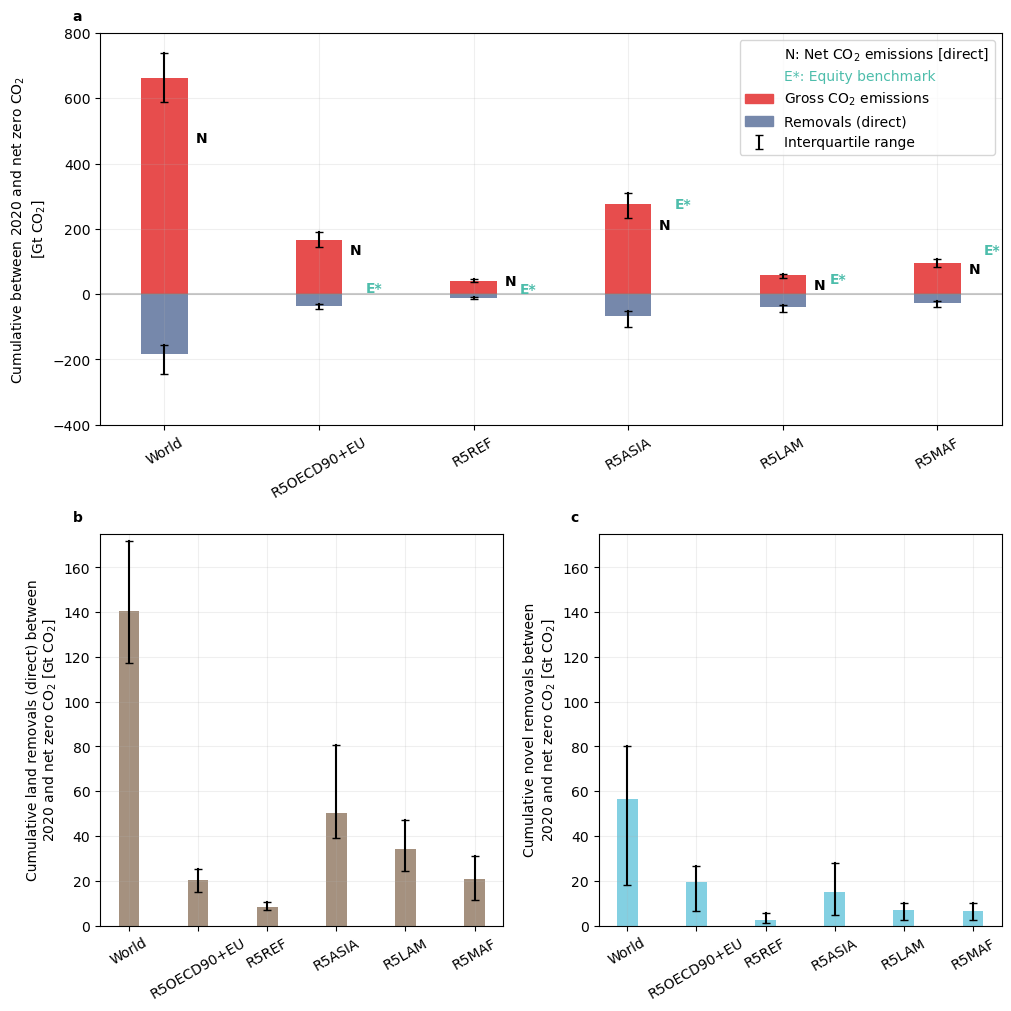

In [11]:
fig, ax = plt.subplot_mosaic(
    [
        ['a', 'a'],
        ['b', 'c']
    ],
    figsize=(10,10),
    constrained_layout=True
)
tot = []
for i, region in enumerate(
    [
        'World',
        'R5OECD90+EU',
        'R5REF',
        'R5ASIA',
        'R5LAM',
        'R5MAF'
    ]
):
    # First, we calculate the cumulative gross CO2 emissions per region
    med, lo, hi = return_cumulative_elements_for_plot(
        variable_components[1],
        region
    )
    plot_bar_errors(
        ax['a'],i,med,lo,hi,'#e74d4d',0
    )
    bottom = 0
    med, lo, hi = return_cumulative_elements_for_plot(
        variable_components[0],
        region
    )
    plot_bar_errors(
        ax['a'],i,-med,-lo,-hi,'#7688ab',0
    )
    med,_,_ = return_cumulative_elements_for_plot(
        'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
        region
    )
    ax['a'].text(
        s='N',
        x=i+0.2,
        y=med.round(0),
        weight='bold'
    )
    # Now plot the fair share estimate
    if region!='World':
        fair_share_benchmark = (
            fair_shares
            .loc[
                (f'benchmark_{region}', '50%'),
                'C1'
            ]
        )
        ax['a'].text(
            s='E*',
            x=i+0.3,
            y=fair_share_benchmark.round(0),
            weight='bold',
            color='#4dbdab'
        )
ax['a'].axhline(0, color='grey', alpha=0.4)
ax['a'].set_xticks(range(6))

ax['a'].set_ylim(-400, 800)

# Panel b - composition of land-based removals
land_removals_var = 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct'
novel_removals_var = 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land'
for i, region in enumerate(
    [
        'World',
        'R5OECD90+EU',
        'R5REF',
        'R5ASIA',
        'R5LAM',
        'R5MAF'
    ]
):
    med, lo, hi = return_cumulative_elements_for_plot(
        var=land_removals_var,
        reg=region
    )
    plot_bar_errors(
        ax['b'],i,med,lo,hi,'#a5917f',0
    )
    med, lo, hi = return_cumulative_elements_for_plot(
        var=novel_removals_var,
        reg=region
    )
    plot_bar_errors(
        ax['c'],i,med,lo,hi,'#83d0e2',0
    )

ax['b'].set_ylim(0, 175)
ax['c'].set_ylim(0, 175)

for lab,a in ax.items():
    a.grid(alpha=0.2)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    a.text(0.0, 1.0, lab, transform=a.transAxes + trans,
             va='bottom', weight='bold')
    a.set_xticks(range(6))
    a.set_xticklabels([
        'World',
        'R5OECD90+EU',
        'R5REF',
        'R5ASIA',
        'R5LAM',
        'R5MAF'
    ], rotation=30)

line = Line2D([],[], ls="none", color='black')
barline = LineCollection(np.empty((2,2,2)), color='black')

# Make a custom legend for panel a
custom_legend = [
    Line2D([0], [0], color='w', label='N: Net CO$_2$ emissions [direct]'), 
    Line2D([0], [0], color='w', label='E*: Equity benchmark'),
    Patch(facecolor='#e74d4d', label='Gross CO$_2$ emissions', edgecolor='#e74d4d'),
    Patch(facecolor='#7688ab', label='Removals (direct)', edgecolor='#7688ab'),
    ErrorbarContainer((line, [line], [barline]), has_yerr=True, label='Interquartile range')
]
ax['a'].legend(
    handles=custom_legend,
    labelcolor=[
        'black',
        '#4dbdab',
        'black',
        'black',
        'black'
    ]
)


# Set the y labels as necessary
ax['a'].set_ylabel(
    'Cumulative between 2020 and net zero CO$_2$\n[Gt CO$_2$]'
)

ax['b'].set_ylabel(
    'Cumulative land removals (direct) between\n2020 and net zero CO$_2$ [Gt CO$_2$]'
)

ax['c'].set_ylabel(
    'Cumulative novel removals between\n2020 and net zero CO$_2$ [Gt CO$_2$]'
)


In [12]:
fig.savefig(
    Path(
        'figures/fig2.png'
    ),
    dpi=400,
    bbox_inches='tight'
)